### imports

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import r2_score, roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

In [2]:
# specify your base path
base_path = "/vevo/umair/data/scgpt-depmap"

### cell line separation by tissue of origin

Use this section to evaluate the cell line embeddings.

In [5]:
# specify models to evaluate
models = [
    "pca",
    "nvidia-gf-10m",
    "nvidia-gf-100m",
    "scgpt-public",
    "scgpt-9m-1024-1percent-data",
    "scgpt-9m-1024-10perct-data",
    "scgpt-9m-1024-fix-norm-apr24-data",
    "scgpt-25m-1024-fix-norm-apr24-data",
    "scgpt-70m-0.01xdata",
    "scgpt-70m-0.1xdata",
    "scgpt-70m-1024-fix-norm-apr24-data",
    "scgpt-1_3b-2048",
    "mosaicfm-70m-merged",
    "mosaicfm-v2-1_3b-merged",
    "mosaicfm-70m-adapted-rif"
]

In [6]:
# run UMAP (if it hasn't been run already)
for m in models:
    print(f"{m}...", end="")
    adata = sc.read_h5ad(os.path.join(base_path, f"cell-embs/{m}.h5ad"))
    try:
        umap = adata.obsm["X_umap"]
        print("skipping")
    except KeyError:
        sc.pp.neighbors(adata, use_rep="X")
        sc.tl.umap(adata)
        adata.write_h5ad(os.path.join(base_path, f"cell-embs/{m}.h5ad"))
        print("computed")

pca...skipping
nvidia-gf-10m...skipping
nvidia-gf-100m...skipping
scgpt-public...skipping
scgpt-9m-1024-1percent-data...skipping
scgpt-9m-1024-10perct-data...skipping
scgpt-9m-1024-fix-norm-apr24-data...skipping
scgpt-25m-1024-fix-norm-apr24-data...skipping
scgpt-70m-0.01xdata...skipping
scgpt-70m-0.1xdata...skipping
scgpt-70m-1024-fix-norm-apr24-data...skipping
scgpt-1_3b-2048...skipping
mosaicfm-70m-merged...skipping
mosaicfm-v2-1_3b-merged...skipping
mosaicfm-70m-adapted-rif...skipping


In [7]:
# compute LISI scores
def compute_lisi_scores(emb, labels, k=20):
    nng = kneighbors_graph(emb, n_neighbors=k).tocoo()
    labels = pd.Categorical(labels).codes
    self_id = labels[nng.row]
    ne_id = labels[nng.col]
    _, c = np.unique(labels, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

lisis = {}
for m in models:
    adata = sc.read_h5ad(os.path.join(base_path, f"cell-embs/{m}.h5ad"))
    emb = adata.X
    labels = adata.obs["OncotreeLineage"]
    lisi = compute_lisi_scores(emb, labels)
    lisis[m] = lisi

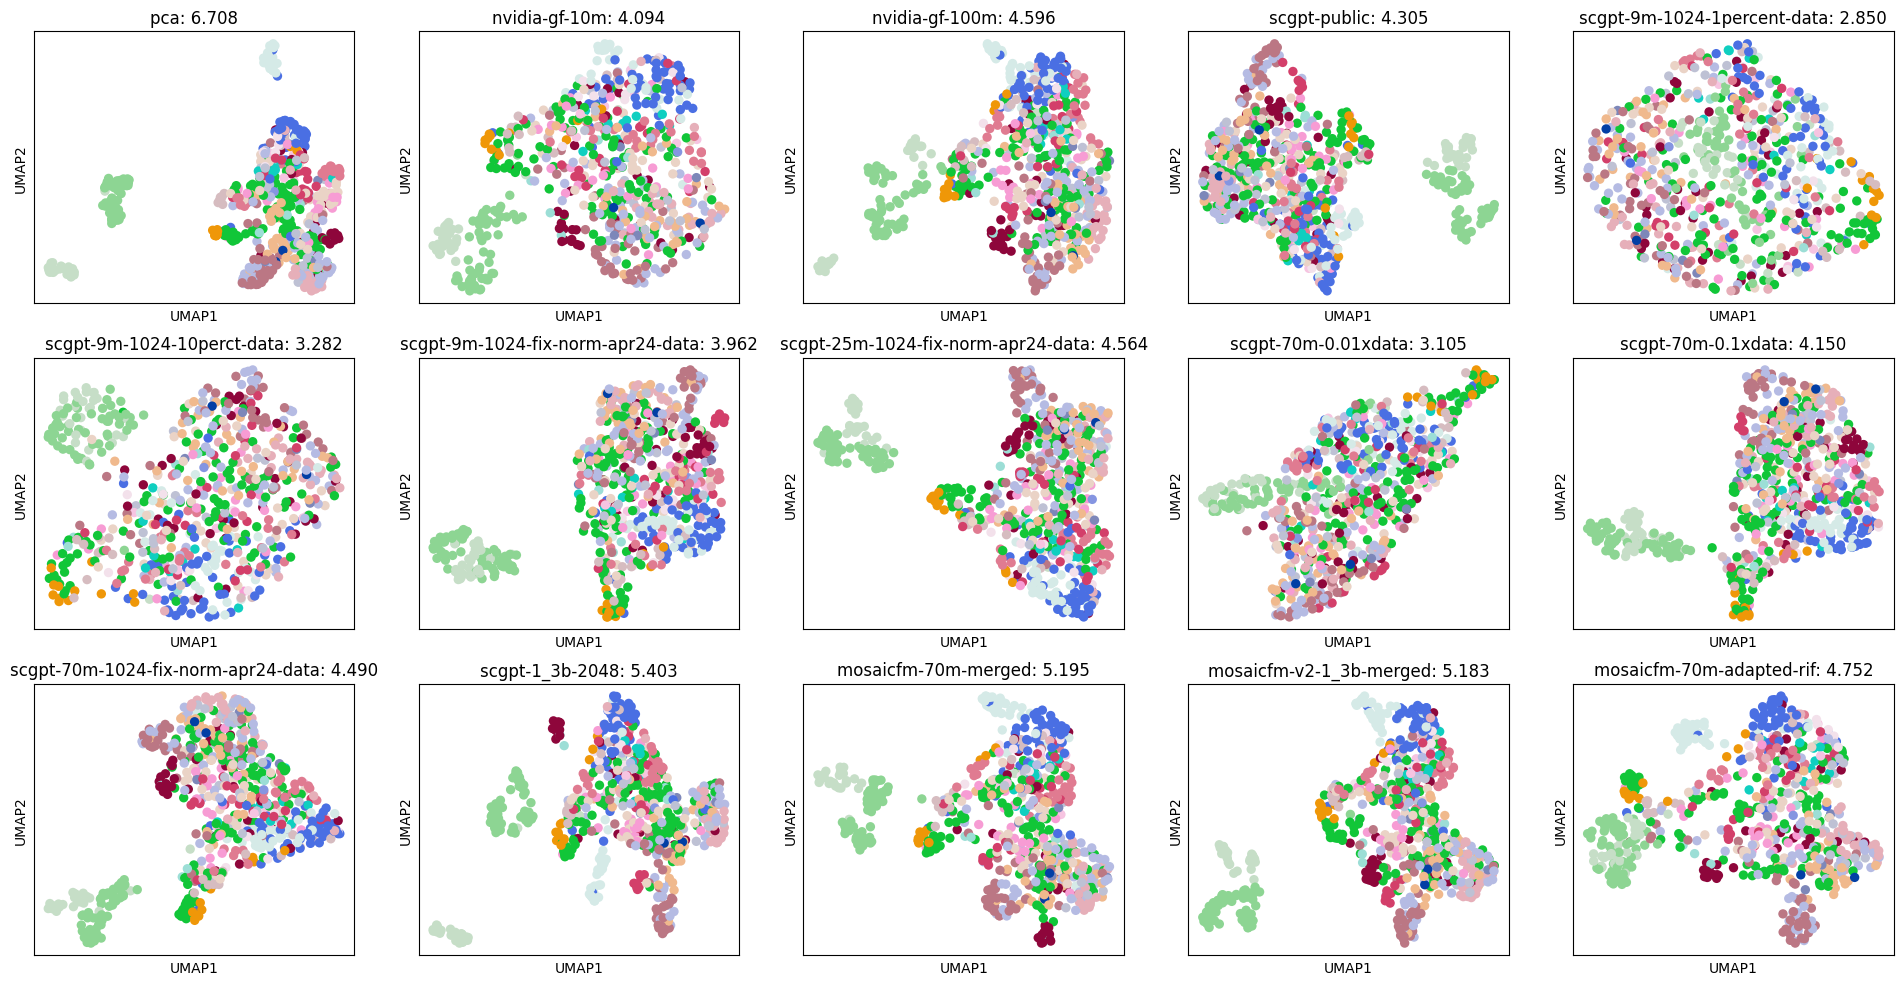

In [8]:
# show LISI scores with UMAPs
fig, axs = plt.subplots(3, 5, figsize=(24, 12))
for i, m in enumerate(models):
    adata = sc.read_h5ad(f"/vevo/umair/data/scgpt-depmap/cell-embs/{m}.h5ad")
    ax = axs[i // 5, i % 5]
    sc.pl.umap(adata, show=False, color="OncotreeLineage", ax=ax, legend_loc=None, title=f"{m}: {lisis[m]:.3f}")

plt.show()

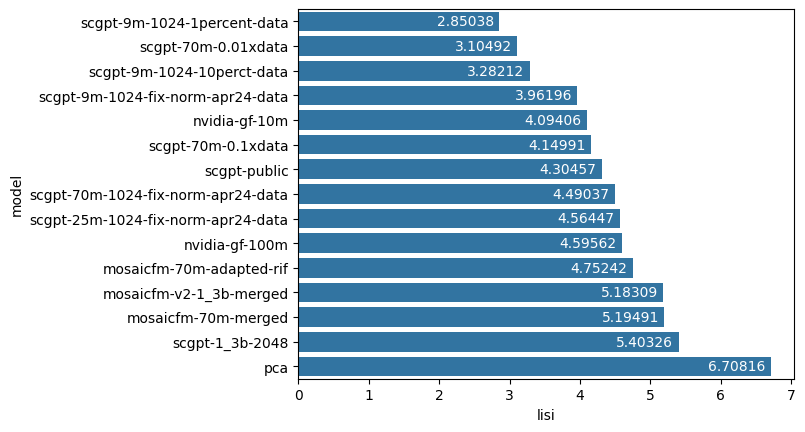

In [9]:
# show LISI scores as barplot
df = pd.DataFrame({"model": lisis.keys(), "lisi": lisis.values()})
df = df.sort_values(by="lisi")
ax = sns.barplot(data=df, x="lisi", y="model")
ax.bar_label(ax.containers[0], fontsize=10, padding=-45, color="white")
plt.show()

### marginal task (boxplot)

Use this section to create boxplots of auROC and auPRC across folds.

In [16]:
# specify models to plot
models = [
    "null-lt5gt70-bin",
    "rfc-loading15-lt5gt70-bin",
    "rfc-scgpt_public-mean-lt5gt70-bin",
    # "rfc-scgpt_9m_1024_1percent_data-mean-lt5gt70-bin",
    # "rfc-scgpt_9m_1024_10perct_data-mean-lt5gt70-bin",
    # "rfc-scgpt_9m_1024_fix_norm_apr24_data-mean-lt5gt70-bin",
    # "rfc-scgpt_25m_1024_fix_norm_apr24_data-mean-lt5gt70-bin",
    # "rfc-scgpt_70m_0.01xdata-mean-lt5gt70-bin",
    # "rfc-scgpt_70m_0.1xdata-mean-lt5gt70-bin",
    "rfc-scgpt_70m_1024_fix_norm_apr24_data-mean-lt5gt70-bin",
    "rfc-scgpt_1_3b_2048-mean-lt5gt70-bin",
    "rfc-mosaicfm_70m_merged-mean-lt5gt70-bin",
    "rfc-mosaicfm_v2_1_3b_merged-mean-lt5gt70-bin"
]

In [17]:
# load results
records = []
for model in models:
    for fold in range(5):
            y_true = np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-true.npy"))
            y_proba = np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-proba.npy"))
            y_pred = np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-pred.npy"))
            auroc = roc_auc_score(y_true, y_proba[:, 1])
            auprc = average_precision_score(y_true, y_proba[:, 1])
            records.append({
                "model": model,
                "fold": fold,
                "auroc": auroc,
                "auprc": auprc
            })

# create DataFrame
df = pd.DataFrame.from_records(records)

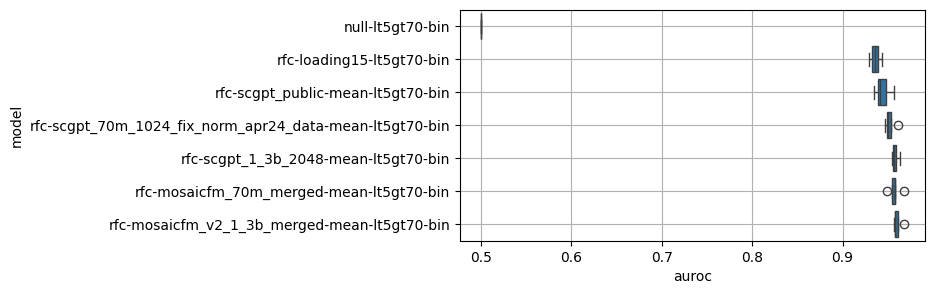

In [21]:
# plot auROC
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df, x="auroc", y="model", ax=ax)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.show()

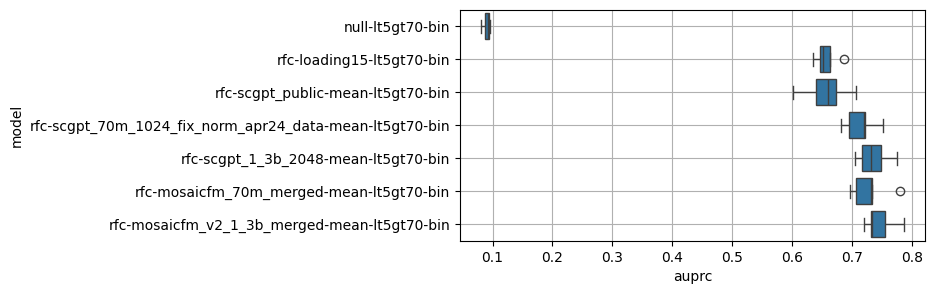

In [22]:
# plot auPRC
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df, x="auprc", y="model", ax=ax)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.show()

### marginal task (curves)

Use this section to create the actual ROC and PR curves.

In [7]:
# specify models to plot
models = [
    "null-lt5gt70-bin",
    "rfc-loading15-lt5gt70-bin",
    "rfc-scgpt_public-mean-lt5gt70-bin",
    "rfc-scgpt_1_3b_2048-mean-lt5gt70-bin",
    "rfc-geneformer-6L-second-last-mean-lt5gt70-bin"
]

<Figure size 640x480 with 0 Axes>

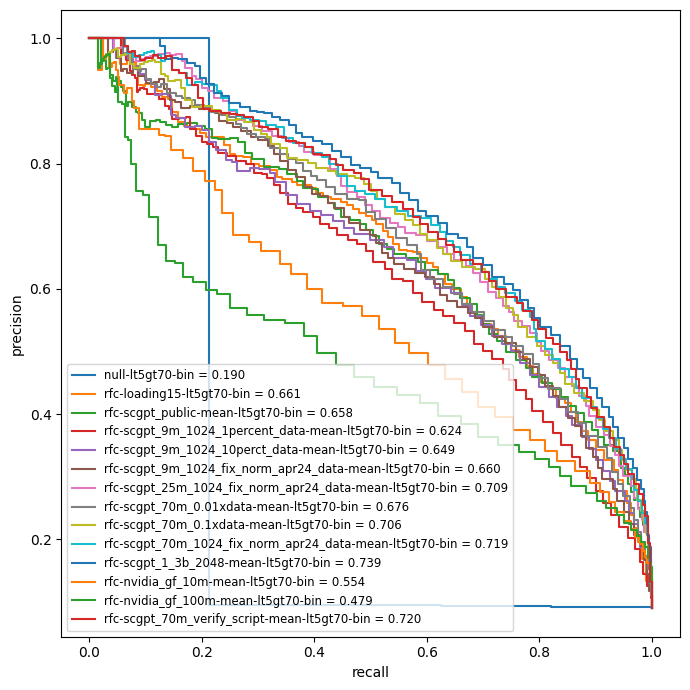

In [11]:
# set up figure
plt.clf()
fig, ax = plt.subplots(figsize=(7, 7))

# iterate over models
for model in models:

    # load results from all folds
    y_true = []
    y_proba = []
    for fold in range(5):
        y_true.append(np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-true.npy")))
        y_proba.append(np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-proba.npy"))[:, 1])

    # concatenate and compute overall curve
    y_true = np.concatenate(y_true)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    auprc = auc(recall, precision)

    # plot model
    l = f"{model} = {auprc:.3f}"
    ax.step(recall, precision, label=l)

# finish plot
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.legend(loc="lower left", fontsize="small")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

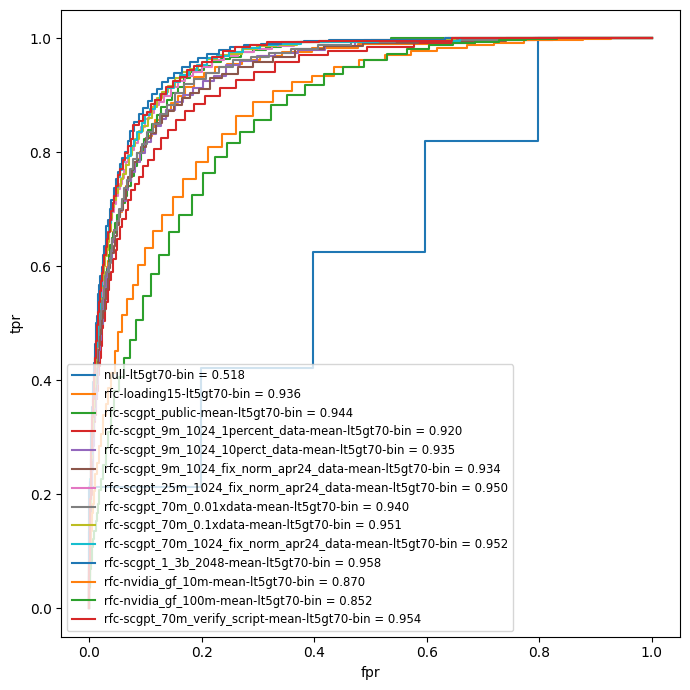

In [12]:
# set up figure
plt.clf()
fig, ax = plt.subplots(figsize=(7, 7))

# iterate over models
for model in models:

    # load results from all folds
    y_true = []
    y_proba = []
    for fold in range(5):
        y_true.append(np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-true.npy")))
        y_proba.append(np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-proba.npy"))[:, 1])

    # concatenate and compute overall curve
    y_true = np.concatenate(y_true)
    y_proba = np.concatenate(y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auroc = auc(fpr, tpr)

    # plot model
    l = f"{model} = {auroc:.3f}"
    ax.step(fpr, tpr, label=l)

# finish plot
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.legend(loc="lower left", fontsize="small")
plt.tight_layout()
plt.show()

### cell line specific task

Use this section to create a boxplot of auROC aggregated across gene strata.

In [3]:
# specify models to plot
models = []
boundaries = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for l, r in zip(boundaries, boundaries[1:]):
    models += [
        f"null-{l}to{r}",
        f"rf-gene_idx+pca15-{l}to{r}",
        f"rf-scgpt_public-{l}to{r}",
        # f"rf-scgpt_9m_1024_1percent_data-{l}to{r}",
        # f"rf-scgpt_9m_1024_10perct_data-{l}to{r}",
        # f"rf-scgpt_9m_1024_fix_norm_apr24_data-{l}to{r}",
        # f"rf-scgpt_25m_1024_fix_norm_apr24_data-{l}to{r}",
        # f"rf-scgpt_70m_0.01xdata-{l}to{r}",
        # f"rf-scgpt_70m_0.1xdata-{l}to{r}",
        f"rf-scgpt_70m_1024_fix_norm_apr24_data-{l}to{r}",
        f"rf-scgpt_1_3b_2048-{l}to{r}",
        # f"rf-nvidia_gf_10m-{l}to{r}",
        # f"rf-nvidia_gf_100m-{l}to{r}",
        f"rf-mosaicfm_70m_merged-{l}to{r}",
        f"rf-mosaicfm_v2_1_3b_merged-{l}to{r}"
    ]

In [4]:
# load results
records = []
for model in models:
    for fold in range(5):
        y_true = np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-true.npy"))
        y_true_bin = y_true > 0.5
        y_pred = np.load(os.path.join(base_path, f"gene-embs/results/{model}-fold-{fold}-val-pred.npy"))
        y_pred_bin = y_pred > 0.5
        r2 = r2_score(y_true, y_pred)
        auroc = roc_auc_score(y_true_bin, y_pred)
        auprc = average_precision_score(y_true_bin, y_pred)
        records.append({
            "model": model,
            "fold": fold,
            "r2": r2,
            "auroc": auroc,
            "auprc": auprc
        })

# create DataFrame of all results
df = pd.DataFrame.from_records(records)

In [5]:
def get_emb(s):
    parts = s.split("-")
    if parts[0] == "null":
        return "null"
    elif parts[-1] == "2" or parts[-1] == "3":
        return parts[0] + "-" + parts[1] + "-" + parts[-1]
    else:
        return parts[0] + "-" + parts[1]

# aggregate results across folds
avg_folds = df.groupby("model", as_index=False).agg(
    mean_r2=("r2", lambda x: x.mean()),
    mean_auroc=("auroc", lambda x: x.mean()),
    mean_auprc=("auprc", lambda x: x.mean())
)

avg_folds["embedding"] = avg_folds["model"].apply(get_emb)

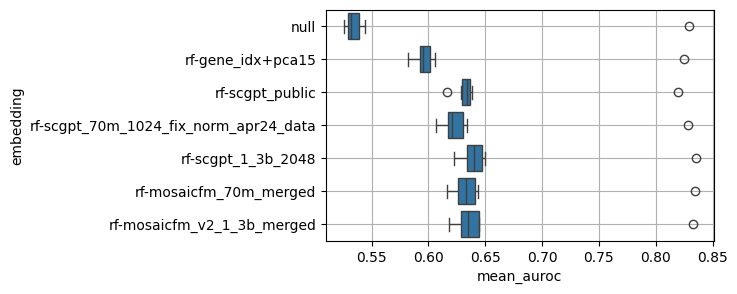

In [6]:
# create plot
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(
    data=avg_folds,
    x="mean_auroc",
    y="embedding",
    order=[
        "null",
        "rf-gene_idx+pca15",
        "rf-scgpt_public",
        # "rf-scgpt_9m_1024_1percent_data",
        # "rf-scgpt_9m_1024_10perct_data",
        # "rf-scgpt_9m_1024_fix_norm_apr24_data",
        # "rf-scgpt_25m_1024_fix_norm_apr24_data",
        # "rf-scgpt_70m_0.01xdata",
        # "rf-scgpt_70m_0.1xdata",
        "rf-scgpt_70m_1024_fix_norm_apr24_data",
        "rf-scgpt_1_3b_2048",
        # "rf-nvidia_gf_10m",
        # "rf-nvidia_gf_100m",
        "rf-mosaicfm_70m_merged",
        "rf-mosaicfm_v2_1_3b_merged"
    ],
    ax=ax
)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.show()